# Import Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

# Load Data, MNIST

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [5]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

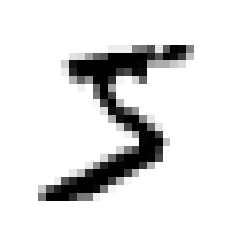

In [6]:
plot_digit(X[0])

In [7]:
y = y.astype(np.uint8)
y[0]

5

#### train-test split

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


# Binary Classifier

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Stochastic Gradient Descent (SGD)** is a simple yet very efficient approach to discriminative learning of **linear classifiers** under convex loss functions such as (linear) **Support Vector Machines and Logistic Regression.** Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.



*  loss="hinge": (soft-margin) linear Support Vector Machine

*  loss="modified_huber": smoothed hinge loss

*  loss="log": logistic regression


Using loss="log" or loss="modified_huber" enables the `predict_proba()` method, which gives a vector of probability estimates $P(Y|x)$ per sample $x$ 

https://scikit-learn.org/stable/modules/sgd.html

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42, loss="log")
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([X[0]])

array([ True])

In [13]:
y_train_5[0]

True

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9648 , 0.9695 , 0.96745])

Above 95% accuracy (ratio of correct predictions) on all cross-validation folds?
This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class

In [15]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None): 
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype='bool')

In [16]:
never5_clf = Never5Classifier()
cross_val_score(never5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time.

# Confusion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
# row : actual
# col : predicted
confusion_matrix(y_train_5, y_pred)

array([[54129,   450],
       [ 1515,  3906]], dtype=int64)

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

a = precision_score(y_train_5, y_pred)
b = recall_score(y_train_5, y_pred)
c = f1_score(y_train_5, y_pred)

print("Precision: ", a)
print("Recall: ", b)
print("F1 score: ", c)

Precision:  0.8966942148760331
Recall:  0.7205312672938572
F1 score:  0.7990181037127954


In [20]:
# F1 score is a harmonic mean of precision and recall.
2/(1/a + 1/b)

0.7990181037127954

## Precision-Recall Trade off
with Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
y_scores = cross_val_predict(log_reg, X_train, y_train_5, cv=3, method="predict_proba")

C:\Users\Choi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Choi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

In [22]:
y_scores = y_scores[:,1]

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [24]:
f1_scores = 2/(1/precisions + 1/recalls)

C:\Users\Choi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


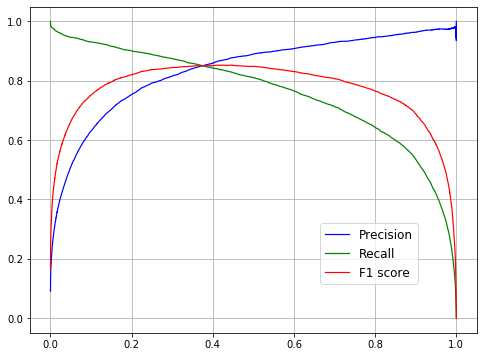

In [25]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=1.2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=1.2)
plt.plot(thresholds, f1_scores[:-1], "r-", label="F1 score", linewidth=1.2)
plt.legend(loc=(0.65,0.15), fontsize=12) 
plt.grid(True)

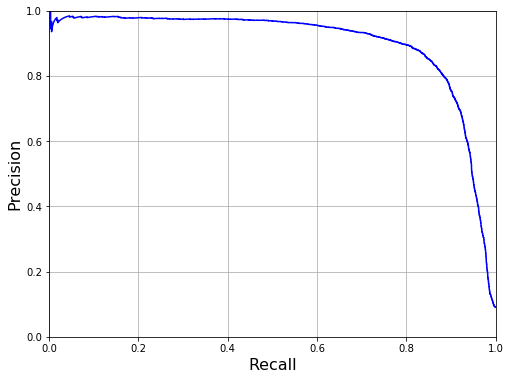

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=1.5)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)

## ROC curve

with Logistic Regression

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

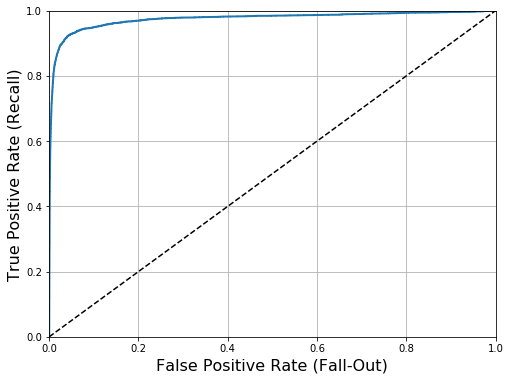

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)                    
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.97486753080908

with Random Forest Regressor

In [30]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [31]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

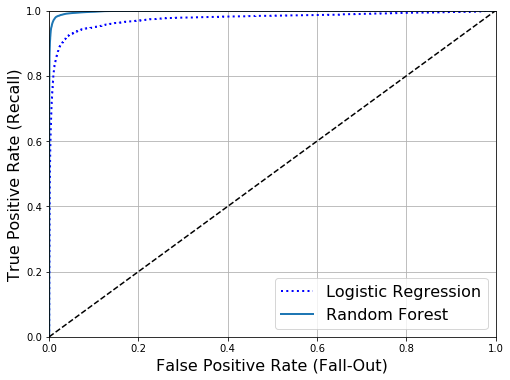

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="Logistic Regression")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [33]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification(OvO, OvA)
Whereas binary classifiers distinguish between two classes, multiclass classifiers (also
called multinomial classifiers) can distinguish between more than two classes.
Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are
capable of handling multiple classes directly. Others (such as Support Vector Machine
classifiers or Linear classifiers) are strictly binary classifiers. However, there are various
strategies that you can use to perform multiclass classification using multiple
binary classifiers.<br><br>
For example, one way to create a system that can classify the digit images into 10
classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a
1-detector, a 2-detector, and so on). Then when you want to classify an image, you get
the decision score from each classifier for that image and you select the class whose
classifier outputs the highest score. This is called the one-versus-all (OvA) strategy
(also called one-versus-the-rest).<br><br>
Another strategy is to train a binary classifier for every pair of digits: one to distinguish
0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the one-versus-one (OvO) strategy. If there are N classes, you need to
train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
binary classifiers! When you want to classify an image, you have to run the image
through all 45 classifiers and see which class wins the most duels. The main advantage
of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish.<br><br>
Some algorithms (such as Support Vector Machine classifiers) scale poorly with the
size of the training set, so for these algorithms OvO is preferred since it is faster to
train many classifiers on small training sets than training few classifiers on large
training sets. For most binary classification algorithms, however, OvA is preferred.

## Scaling

In [34]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9648 , 0.9695 , 0.96745])

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train_5, cv=3, scoring="accuracy")

array([0.9713, 0.9667, 0.9678])

## Error Analysis(?)

In [36]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression()

y_train_pred = cross_val_predict(log_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\Choi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Choi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

array([[5652,    1,   45,   14,   13,   60,   57,   21,   49,   11],
       [   2, 6528,   42,   27,   12,   27,    7,   16,   71,   10],
       [  49,   83, 5234,  126,   79,   32,  100,   81,  146,   28],
       [  24,   37,  169, 5379,   11,  234,   22,   60,  128,   67],
       [  16,   26,   49,   14, 5344,   20,   66,   37,   42,  228],
       [  73,   26,   54,  195,   64, 4666,  112,   29,  142,   60],
       [  48,   17,   65,    7,   64,   95, 5579,    4,   37,    2],
       [  22,   23,   60,   38,   76,   17,    4, 5784,   26,  215],
       [  52,  140,  100,  163,   38,  185,   51,   24, 5015,   83],
       [  20,   23,   23,   84,  173,   51,    3,  214,   57, 5301]],
      dtype=int64)

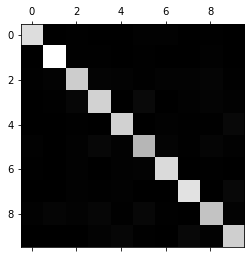

In [37]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [38]:
norm_conf_mx = conf_mx / conf_mx.sum(axis=1, keepdims=True)

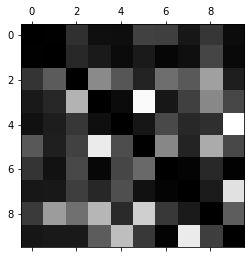

In [39]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# Multilabel Classification
Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance. For example,
consider a face-recognition classifier: what should it do if it recognizes several people
on the same picture? Of course it should attach one tag per person it recognizes. Say
the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then
when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning
“Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple
binary tags is called a multilabel classification system.
<br><br>
**KNeighborsClassifier supports multilabel classification, but not all classifiers do.**

In [40]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

(-0.5, 27.5, 27.5, -0.5)

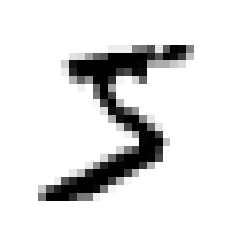

In [42]:
plt.imshow(X[0].reshape(28,28), cmap=plt.cm.binary)
plt.axis("off")

In [43]:
y_multilabel[0]

array([False,  True])

In [44]:
knn_clf.predict([X[0]])

array([[False,  True]])

The labels are (Large, Odd). The digit 5 is indeed not large (False) and odd (True).

# Exercise
# 1.

In [45]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [46]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
pred = knn_clf.predict(X_test)
accuracy_score(y_test, pred)